In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import math
from IPython.display import display, Markdown
from datetime import datetime
import requests
import os
import sys 
import re

GENERATION_DAYS=5
TODAY=datetime.today().strftime("%Y-%m-%d")
SAMPLE_DATE=TODAY
SAMPLE_FILE=f"archive/{SAMPLE_DATE}/last-6-months-nsw.csv"
SAMPLE_14DAYS=f"archive/{SAMPLE_DATE}/last-14-days-nsw.csv"
ALL_VIC_CASES='archive/2021-07-12/all-vic-cases.csv'
QUARANTINE='archive/2021-07-16/quarantine.csv'

pd.set_option('display.max_rows', None)

In [2]:
def load_data(fn):
    df=pd.read_csv(fn).rename({
        'Date': 'date',
        'Overseas-acquired': 'overseas',
        'Overseas acquired': 'overseas',
        'Known local source': 'local',
        'Unknown local source (community spread)': 'unknown', 
        'Interstate travel': 'interstate',
        'Known local source inside HQ': 'local-hq',
        'Under investigation': 'under-investigation'
    }, axis=1)
    try:
        df["local-hq"] is None
    except KeyError as e:
        df["local-hq"] = 0
    df=calc_cumulative(df)
    return edit_dates(df)

def load_quarantine(fn):
    df=pd.read_csv(fn).rename({
        'Hotel Quarantine': 'hotel-quarantine',
        'Local Quarantine / Isolation': 'local-quarantine',
        'No Quarantine / Unspecified': 'no-quarantine',
        'Not Announced / Under investigation': 'under-investigation'
    }, axis=1)
    df['total']=df['under-investigation']+df['no-quarantine']
    df['cumulative'] = df['total'].cumsum()    
    return edit_dates(df)

def rewrite_date(d):
    p = d.split('/')
    return '-'.join(['20'+p[2], p[1], p[0]])

def calc_cumulative(df):
    df['total']=df['local']+df['unknown']+df['under-investigation']+df['local-hq']
    df['cumulative'] = df['total'].cumsum()    
    return df

def select_outbreak(df, condition=None):
    if condition is None:
        condition = df.index >= 0
    subset_df = df.loc[condition].copy().reset_index(drop=True)
    start_total, start_cumulative = subset_df[['total', 'cumulative']].head(1).values[0]
    subset_df['cumulative'] = subset_df['cumulative'] - start_cumulative + start_total
    
    endog=np.log(subset_df['cumulative'])
    exog=sm.add_constant(subset_df.index)
    model = RollingOLS(endog=endog, exog=exog, window=GENERATION_DAYS, min_nobs=GENERATION_DAYS)
    subset_df['ols-growth-rate']=((np.exp(model.fit().params['x1'])-1)*100)
    subset_df['ratio-growth-rate']=((subset_df['cumulative']/subset_df['cumulative'].shift(GENERATION_DAYS))**(1/GENERATION_DAYS)-1)*100    
    subset_df['Reff'] = ((subset_df['ols-growth-rate']+100)/100)**GENERATION_DAYS
    subset_df['doubling-period'] = np.log(2)/np.log(((subset_df['ols-growth-rate']+100)/100))
    
    subset_df['ols-growth-rate-median'] = subset_df['ols-growth-rate'].rolling(GENERATION_DAYS, min_periods=1).median()
    subset_df['ols-growth-rate-min'] = subset_df['ols-growth-rate'].rolling(GENERATION_DAYS, min_periods=1).min()
    subset_df['ols-growth-rate-max'] = subset_df['ols-growth-rate'].rolling(GENERATION_DAYS, min_periods=1).max()

    endog=np.log((100+subset_df['ols-growth-rate'])/100)
    exog=sm.add_constant(subset_df.index)
    model = RollingOLS(endog=endog, exog=exog, window=GENERATION_DAYS, min_nobs=GENERATION_DAYS)
    subset_df['ols-growth-rate-decay']=((np.exp(model.fit().params['x1'])-1)*100)

    shift_df=subset_df.shift(1)
    subset_df['one-day-error']=subset_df['cumulative']-np.round(shift_df['cumulative']*((shift_df['ols-growth-rate']+100)/100))
    subset_df['one-day-projection-cumulative']=np.round(subset_df['cumulative']*((subset_df['ols-growth-rate']+100)/100))
    subset_df['one-day-projection-total']=subset_df['one-day-projection-cumulative']-subset_df['cumulative']
    
    
    subset_df['median']=(((subset_df['ols-growth-rate-median']+100)/100)**7*subset_df['cumulative']).shift(7)
    subset_df['min']=(((subset_df['ols-growth-rate-min']+100)/100)**7*subset_df['cumulative']).shift(7)
    subset_df['max']=(((subset_df['ols-growth-rate-max']+100)/100)**7*subset_df['cumulative']).shift(7)
    subset_df['last']=(((subset_df['ols-growth-rate']+100)/100)**7*subset_df['cumulative']).shift(7)
    
    subset_df["err"] = modeling_errors(subset_df, None)
    return subset_df
    
def edit_dates(df):
    newyear=df['date'][df['date']=='01/01'].index.values
    if len(newyear) > 0:
        df.loc[df.index < newyear[0],['date']]=df['date'].loc[df.index < newyear[0]]+'/20'
    else:
        newyear=[0]
    df.loc[df.index >= newyear[0],['date']]=df['date'].loc[df.index >= newyear[0]]+'/21'
    df['date']=df['date'].apply(rewrite_date)
    return df

def load_vic_data(fn):
    df=pd.read_csv(fn).rename({
        'Acquired in Australia, unknown source': 'unknown',
        'Contact with a confirmed case	': 'local',
        'Travel overseas': 'overseas'
    })

    df['count']=1
    df=df.pivot_table(index=['diagnosis_date'], columns=['acquired'], values=['count'], aggfunc=np.sum)
    
    tmp=df
    df=pd.DataFrame(data=df.values, columns=['unknown', 'local', 'overseas'])
    df[df.loc[:,['unknown']].isna()]=0
    df[df.loc[:,['local']].isna()]=0
    df[df.loc[:,['overseas']].isna()]=0
    df['under-investigation']=0
    
    df=pd.DataFrame(data=df.values, columns=['unknown', 'local', 'overseas', 'under-investigation'], dtype=int)
    df['date']=tmp.index

    df['total']=df['local']+df['unknown']+df['under-investigation']
    df['cumulative'] = df['total'].cumsum()    
    return df

def amnesic_growth(rate=1.5, days=100, window_size=14):
    window = np.zeros(shape=(window_size))
    population = 0.0
    cumulative = 0
    for d in range(0,days):
        old_population = window[d%window_size]
        if (population-window[d%window_size]) > 0:
            next_population = (population-window[d%window_size]) * (rate-1) + population
        elif d == 0:
            next_population = 1
        else:
            next_population = population
        total = int(next_population) - int(population) 
        cumulative += total
        prev_population = population
        population = next_population
        window[d%window_size] = next_population
        yield d, total, cumulative, population, prev_population, old_population
        
def modeling_errors(df, clip=None):
    err = (df['min']-df['cumulative'])/(df['cumulative']-df['cumulative'].shift(7))*100
    if clip:
        return err.apply(lambda v: clip if v > clip else v)
    else:
        return err

class PhasePlot:
    
    def __init__(self): 
        self.ax = None
        self.frames = []
        self.legend = []
        self.colors = []

    def reset_dimensions(self):
        self.ax.vlines(0,1, np.max([df['total'].max() for df in self.frames])*1.2, linestyles='dashed', color="black")
        err_max = np.max([ np.max(np.abs(df[df['err'].isna() == False]['err'])) for df in self.frames])*1.1
        self.err_max = err_max
        self.ax.set_xbound(-100, 100)
        self.annotations_x = err_max*1.1
        self.annotations_x_delta = err_max*2/100
        self.annotations_y = np.max([ np.max(np.abs(df[df['total'].isna() == False]['total'])) for df in self.frames])*0.8
        self.annotations_y_delta = np.log(self.annotations_y)/30
        
    def add(self, df, offset=0, color=None, legend=None):
        if color==None:
            color=f"C{len(self.colors)}"
        slice = df[df.index>=offset].copy()
        slice.loc[slice['total']==0,'total']=1
        if len(self.frames) == 0:
            self.ax = slice.plot(x='err', y='total', figsize=(16,10), color=color)
            self.ax.set_yscale('log')
            self.ax.set_xlabel("Modeling Error %")
            self.ax.set_ylabel("New Cases")
        else:
            self.ax.plot(slice['err'], slice['total'], color=color)

        self.frames.append(slice)
        self.colors.append(color)
        self.reset_dimensions()
        self.legend.append(legend)
        self.ax.legend(self.legend)
        self.ax.scatter(x=slice.err, y=slice.total, color=color)
        return len(self.frames)-1

    def add_label(self, index, date, text):
        df = self.frames[index]
        
        rec = df.loc[df["date"]==date, ["err", "total", "cumulative"]]
        err, total, cumulative = rec.values[0]
        self.add_xy_label(
            index, 
            err, 
            total, 
            f"{date} - day:{rec.index.values[0]}, new:{int(total)}, cases:{int(cumulative)} - {text}")
        return
    
    def add_xy_label(self, index, err, total, text):
        self.ax.text(
            self.annotations_x,
            self.annotations_y, 
            text, 
            color=self.colors[index]
        )
        x=[self.annotations_x-self.annotations_x_delta*2, err]
        y=[self.annotations_y, total]
        self.ax.plot(x, y, color="black", linestyle="dotted")
        self.ax.scatter(x=[err], y=[total], color="black")
        self.annotations_y = np.exp(np.log(self.annotations_y) - self.annotations_y_delta)
        return
        

class GrowthPlot:
    def __init__(self):
        self.frames = []
        self.colors = []
        self.legend = []
        pass
    
    def add(self, df, offset=0, color=None, legend=None):
        if color==None:
            color=f"C{len(self.colors)}"
        slice = df[df.index>=offset].copy()
        if len(self.frames) == 0:
            self.ax = slice['ols-growth-rate'].plot(title=f"Daily Cumulative Growth % ({SAMPLE_DATE})", figsize=(10,10), color=color)
            self.ax.set_xlabel("Days Since 1st Case")
            self.ax.set_ylabel("Daily Cumulative Growth %")
            self.ax.set_yticks(range(0,110,10))
#            self.ax.text(80,101, "Based on OLS regression of observed 5-day growth")
            self.ax.grid()
        else:
            self.ax.plot(slice['ols-growth-rate'], color=color)

        self.frames.append(slice)
        self.colors.append(color)
        self.reset_dimensions()
        self.legend.append(legend)
        self.ax.legend(self.legend)
        return len(self.frames)-1

    def reset_dimensions(self):
        pass
    
def derive_growth_params(df):
    endog=np.log(df['ols-growth-rate'])
    exog=sm.add_constant(df.index)
    model = RollingOLS(endog=endog, exog=exog, window=GENERATION_DAYS, min_nobs=GENERATION_DAYS)
    params=np.exp(model.fit().params.mean())
    return (params["const"], params["x1"])


def project_cumulative(df, days, rate):
    last = df.tail(1)
    max_index = last.index.values[0]
    max_cumulative = last.cumulative.values[0]
    df = df.reindex(range(0, max_index+days+1))
    
    growth = ((rate+100)/100)**(np.array(range(1, days+1)))
    df.loc[df.index > max_index, 'cumulative'] = np.int32(max_cumulative*growth)
    df.loc[df.index > max_index, 'total'] = df.loc[df.index > max_index, 'cumulative'] - df.loc[df.index > max_index-1, 'cumulative'].shift(1)
    return df

def project_ols_growth_rate_min(df, days, growth_decay_rate):
    last = df.tail(1)
    index = last.index.values[0]
    cumulative = last.cumulative.values[0]
    ols_growth_rate = last['ols-growth-rate-min'].values[0]
    
    tuples = []
    for d in range(1, days+1):
        ols_growth_rate = ols_growth_rate*growth_decay_rate
        cumulative = cumulative * (ols_growth_rate+100)/100
        tuples.append(np.array([cumulative]))
        
    df = df.reindex(range(0, index+days+1))
    df.loc[df.index > index, 'cumulative'] = tuples
    df.loc[df.index > index, 'total'] = df.loc[df.index > index, 'cumulative'] - df.loc[df.index > index-1, 'cumulative'].shift(1)
        
    return df
    
def horizon(df, days, steps=100):
    
    last = df.tail(1)
    index = last.index.values[0]
    cumulative = last["cumulative"].values[0]
    ols_growth_rate_min = last["ols-growth-rate-min"].values[0]
    ols_growth_rate_max = last["ols-growth-rate-max"].values[0]
    
    max_rate = np.sqrt(ols_growth_rate_max/ols_growth_rate_min) * ols_growth_rate_max
    #min_rate = np.sqrt(ols_growth_rate_min/ols_growth_rate_max) * ols_growth_rate_min
    min_rate = ols_growth_rate_min/5
        
#     max_rate = ols_growth_rate_max
#     min_rate = ols_growth_rate_min
    rate_step = (max_rate/min_rate)**(1/steps)
    
    c_rate = (((100+ols_growth_rate_min)/100)**days) * cumulative
    t_rate = np.round(c_rate*(1-100/(100+ols_growth_rate_min)))
    
    tuples=[]
    for s in range(0, steps):
        r = min_rate*(rate_step ** (s+1))
        c = (((100+r)/100)**days)*cumulative
        t = np.round(c*(1-100/(100+r)))
        e = (c_rate-c)/(c-cumulative)*100
        tuples.append(np.array([r,c,e,t]))
        
    df = pd.DataFrame(index=range(0,steps), columns=["ols-growth-rate", "cumulative", "err", "total"], data=tuples)
    return df[np.abs(df["err"])<=100]


def plot_derivatives(df, split=None, dataset="???"):
    
    out=pd.DataFrame(index=df.index)
    
    cumulative_max=int(np.round(df["cumulative"].max()))
    total_max=int(np.round(df["total"].max()))
    ols_growth_rate_max=int(np.round(df["ols-growth-rate"].max()))
    ols_growth_rate_decay_max=int(np.round(np.abs(df["ols-growth-rate-decay"]).max()))
    
    out["cumulative"]=df["cumulative"]/cumulative_max
    out["total"]=df["total"]/total_max
    out["growth"]=df["ols-growth-rate"]/ols_growth_rate_max
    out["decay"]=df["ols-growth-rate-decay"]/ols_growth_rate_decay_max
    
    if split:
        past   = out[out.index < split]
        future = out[out.index >= split]
    else:
        past = out
        future = None

    ax=past.plot(figsize=(10,10), title=f"Derivatives Past and Present ({dataset})")
    ax.legend([
        f"cumulative ({cumulative_max})",
        f"daily - first derivative ({total_max})", 
        f"growth - 2nd derivive ({ols_growth_rate_max})", 
        f"decay - 3rd derivtive ({ols_growth_rate_decay_max})"])
    ax.set_xlabel("day of outbreak")
    ax.set_ylabel("relative scale")
    if not future is None:
        ax.plot(future['cumulative'], linestyle='dotted')
        ax.plot(future['total'], linestyle='dotted')
        ax.plot(future['growth'], linestyle='dotted')
        ax.plot(future['decay'], linestyle='dotted')
    ax.grid()
    return ax


def sweep_downloads(date):

    DATE_ARCHIVE=f"archive/{date}"
    os.makedirs(DATE_ARCHIVE, exist_ok=True)
    DOWNLOADS=f"{os.environ['HOME']}/Downloads"
    
    pattern=re.compile("Last (14 days|6 months) \\((new|true)\\)( *\\([0-9]*\\))*")
    files = [f for f in os.listdir(DOWNLOADS) if pattern.match(f)]
    
    for f in files:
        src=f"{DOWNLOADS}/{f}"
        print(f"found \"{src}\"", file=sys.stderr)

    for f in files:
        src=f"{DOWNLOADS}/{f}"
        if f == 'Last 14 days (new).csv':
            nf = 'last-14-days-nsw.csv'
        elif f == 'Last 6 months (true).csv':
            nf = 'last-6-months-nsw.csv'
        else:
            print("rm {f}", file=sys.stderr)
            os.unlink(f"{src}")
            continue

        dst=f"{DATE_ARCHIVE}/{nf}"

        os.rename(src,dst)    
        print(f"mv {src} {dst}", file=sys.stderr) 


In [3]:
sweep_downloads(TODAY)

In [4]:
nsw_df = load_data(SAMPLE_FILE)
nsw_14days_df = load_data(SAMPLE_14DAYS)
vic_df = load_vic_data(ALL_VIC_CASES)
quarantine_df = load_quarantine(QUARANTINE)

In [5]:
join_index=nsw_df.loc[nsw_df["date"] == nsw_14days_df.head(1)['date'].values[0]].index.values[0]
nsw_14days_df['renumber'] = range(join_index, join_index+len(nsw_14days_df))
nsw_14days_df=nsw_14days_df.set_index('renumber', drop=True)
nsw_df.update(nsw_14days_df, overwrite=True)
nsw_df=calc_cumulative(nsw_df)

In [6]:
avalon = select_outbreak(nsw_df, (nsw_df['date'] >= '2020-12-17') & (nsw_df['date'] <= '2021-01-16'))
bondi = select_outbreak(nsw_df, (nsw_df['date'] >= '2021-06-17'))
#bondi=bondi.head(len(bondi)-1)
vic_outbreak = select_outbreak(vic_df, (vic_df['date'] >= '2020-05-27') & (vic_df['date'] <= '2020-10-29'))
vic_growth_params=derive_growth_params(vic_outbreak[(vic_outbreak.index >= 70) & (vic_outbreak.index < 120)])
bondi_growth_params=derive_growth_params(bondi.tail(8))
N=1
bondi_growth_params_3=derive_growth_params(bondi.tail(8+N).head(8))
bondi_projection_1=select_outbreak(project_ols_growth_rate_min(bondi, 84, vic_growth_params[1]))
bondi_projection_2=select_outbreak(project_ols_growth_rate_min(bondi, 84, bondi_growth_params[1]))
bondi_projection_3=select_outbreak(project_ols_growth_rate_min(bondi.head(len(bondi)-N), 84+N, bondi_growth_params_3[1]))
bondi_horizon=horizon(bondi, 7)
bondi_horizon_old=horizon(bondi.head(len(bondi)-7),7)
bondi_horizon_very_old=horizon(bondi.head(len(bondi)-14),7)

In [7]:
VIC_EXTRA_DAYS=40
vic_partial=vic_outbreak.head(len(bondi)+VIC_EXTRA_DAYS)
vic_partial_growth_params=derive_growth_params(vic_partial)
vic_projection=select_outbreak(project_ols_growth_rate_min(vic_partial, len(vic_outbreak)-len(bondi)-VIC_EXTRA_DAYS, vic_partial_growth_params[1]))
len(vic_partial)

77

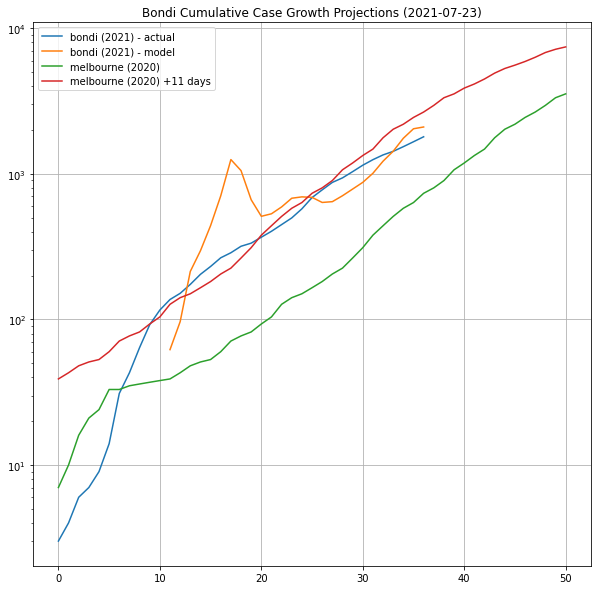

In [8]:
output=pd.DataFrame(columns=['cumulative', 'min', 'vic'])
output[['min', 'cumulative']] = bondi[['min','cumulative']]
output=output.reindex([r for r in range(0, len(bondi)+14)])
output['vic'] = vic_outbreak['cumulative']
x=11
output['vic-offset'] = vic_outbreak['cumulative'].shift(-x)
ax=output.plot(figsize=(10,10))
ax.set_yscale('log')
ax.grid()
ax.set_title(f'Bondi Cumulative Case Growth Projections ({SAMPLE_DATE})')
ax.legend([
    'bondi (2021) - actual', 
    'bondi (2021) - model', 
    'melbourne (2020)',
    f'melbourne (2020) +{x} days'
])
ax.figure.savefig(f'archive/{SAMPLE_DATE}/cumulative-partial.png')
_=_

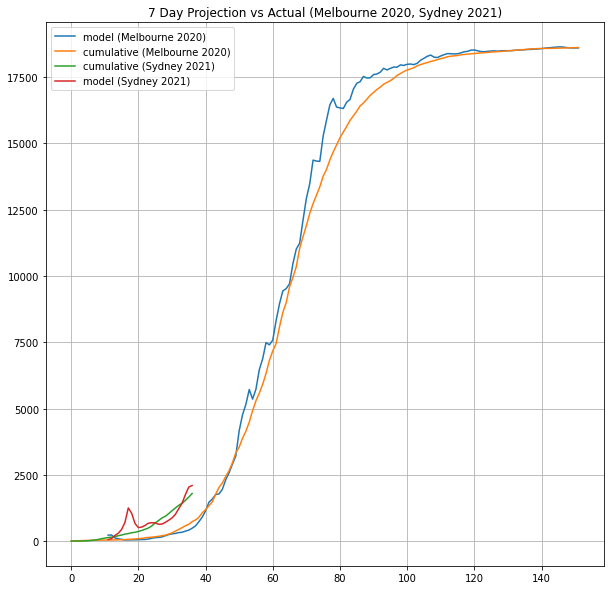

In [9]:
df=vic_outbreak
ax=df[['min', 'cumulative']].plot(figsize=(10,10))
#ax.set_yscale('log')
ax.grid()
ax.plot(bondi['cumulative'])
ax.plot(bondi['min'])
ax.legend(['model (Melbourne 2020) ', 'cumulative (Melbourne 2020)','cumulative (Sydney 2021)',  'model (Sydney 2021) '])
ax.set_title("7 Day Projection vs Actual (Melbourne 2020, Sydney 2021)")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/cumulative-full.png')

_=_

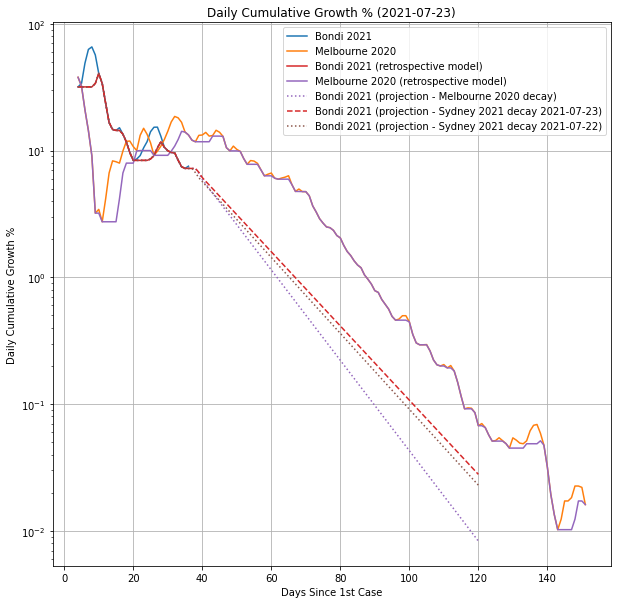

In [10]:
gp=GrowthPlot()
gp.add(bondi, offset=0, legend="Bondi 2021")
#gp.add(avalon, offset=0, legend="Avalon 2020")
gp.add(vic_outbreak, offset=0, legend="Melbourne 2020")
gp.ax.plot(bondi['ols-growth-rate-min'],color="C3")
gp.ax.plot(vic_outbreak['ols-growth-rate-min'], color="C4")
gp.ax.plot(bondi_projection_1['ols-growth-rate-min'], linestyle='dotted', color='C4')
gp.ax.plot(bondi_projection_2['ols-growth-rate-min'], linestyle='dashed', color='C3')
gp.ax.plot(bondi_projection_3['ols-growth-rate-min'], linestyle='dotted', color='C5')
gp.ax.set_yscale('log')
gp.legend = gp.legend+[
    'Bondi 2021 (retrospective model)', 
    'Melbourne 2020 (retrospective model)', 
    'Bondi 2021 (projection - Melbourne 2020 decay)',
    'Bondi 2021 (projection - Sydney 2021 decay 2021-07-23)',
    'Bondi 2021 (projection - Sydney 2021 decay 2021-07-22)'
]
gp.ax.legend(gp.legend)
gp.ax.figure.savefig(f'archive/{SAMPLE_DATE}/cumulative-growth.png')

#gp.add(vic_outbreak.shift(-11), offset=0, legend="Melbourne 2020 (shifted)")
_=_

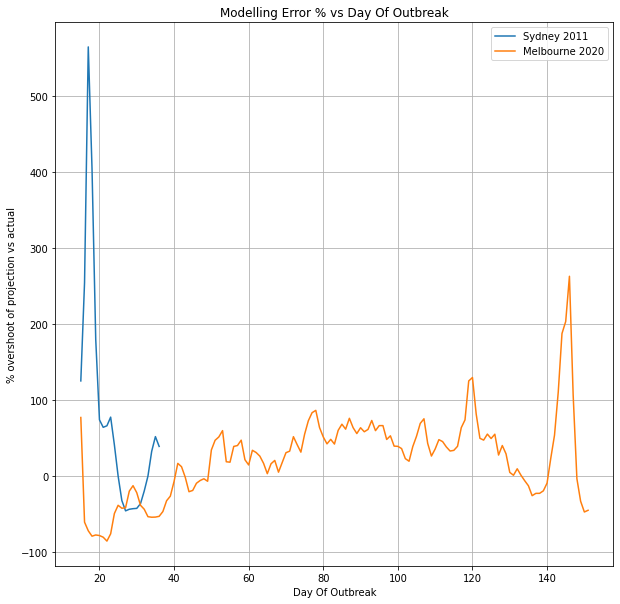

In [11]:
output=pd.DataFrame()
output['vic'] = modeling_errors(vic_outbreak)
output["vic"]
output["bondi"] = modeling_errors(bondi)
#output["avalon"] = modeling_errors(avalon)
                                    
ax=output.loc[output.index >= 15, ['bondi', 'vic', ]].plot(figsize=(10,10))
ax.grid()                         
ax.set_title("Modelling Error % vs Day Of Outbreak")
ax.set_xlabel("Day Of Outbreak")
ax.set_ylabel("% overshoot of projection vs actual")
ax.legend(['Sydney 2011', 'Melbourne 2020'])
ax.figure.savefig(f'archive/{SAMPLE_DATE}/modellng-error.png')
_=_

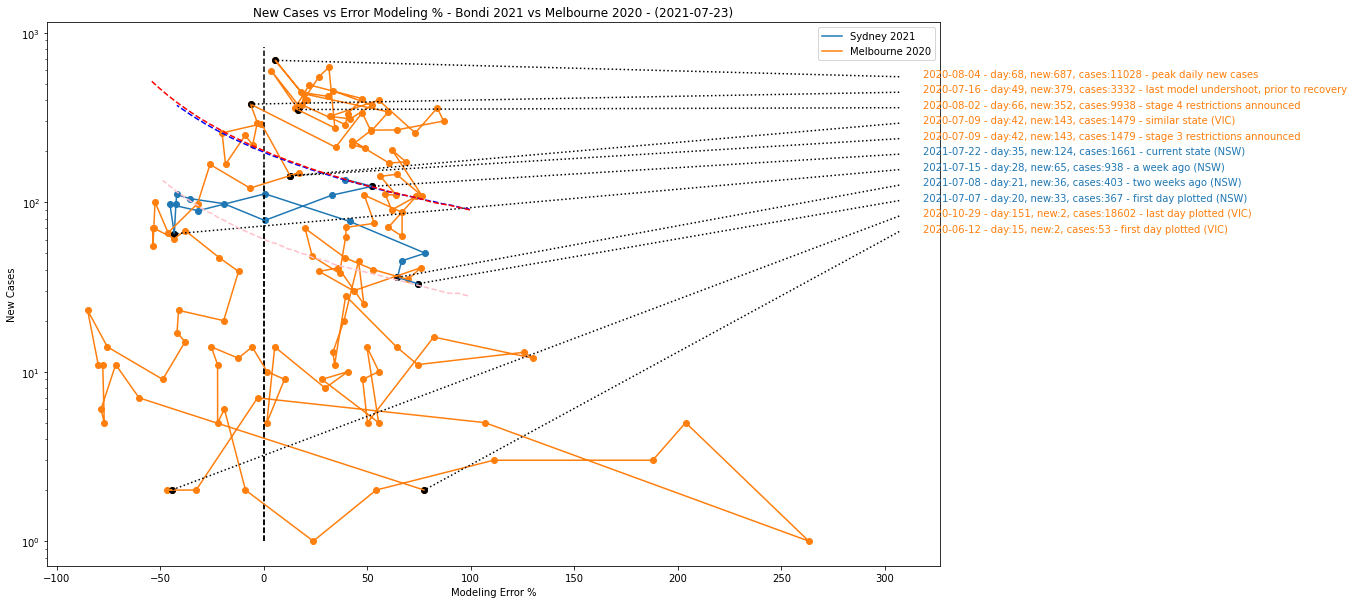

In [12]:
pp = PhasePlot()
bondi_idx=pp.add(bondi, offset=20, legend="Sydney 2021", color="C0") # 20
vic_idx=pp.add(vic_outbreak, offset=15, legend="Melbourne 2020", color="C1") # 15

pp.ax.set_title(f"New Cases vs Error Modeling % - Bondi 2021 vs Melbourne 2020 - ({SAMPLE_DATE})")
first_case=pp.frames[vic_idx].head(1)['date']
last_case=pp.frames[vic_idx].tail(1)[['date', 'total', 'err']]
first_case_nsw=pp.frames[bondi_idx].head(1)['date']

pp.add_label(vic_idx, "2020-08-04", "peak daily new cases")
pp.add_label(vic_idx, "2020-07-16", "last model undershoot, prior to recovery")
pp.add_label(vic_idx, "2020-08-02", "stage 4 restrictions announced")
pp.add_label(vic_idx, "2020-07-09", "similar state (VIC)")
pp.add_label(vic_idx, "2020-07-09", "stage 3 restrictions announced")
pp.add_label(bondi_idx, "2021-07-22", "current state (NSW)")
pp.add_label(bondi_idx, "2021-07-15", "a week ago (NSW)")
pp.add_label(bondi_idx, "2021-07-08", "two weeks ago (NSW)")
pp.add_label(bondi_idx, first_case_nsw.values[0], f"first day plotted (NSW)")
pp.add_label(vic_idx, last_case.values[0][0], f"last day plotted (VIC)")
pp.add_label(vic_idx, first_case.values[0], f"first day plotted (VIC)")

# pp.add_label(vic_idx, "2020-08-09", "1 week after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-08-16", "2 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-08-23", "3 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-08-30", "4 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-06", "5 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-13", "6 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-10", "10 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-20", "7 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-03", "9 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-24", "12 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-27", "8 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-17", "11 weeks after stage 4 restrictions announced")

pp.ax.plot(bondi_horizon["err"], bondi_horizon["total"], linestyle="dashed", color="blue")
pp.ax.plot(bondi_horizon_old["err"], bondi_horizon_old["total"], linestyle="dashed", color="red")
pp.ax.plot(bondi_horizon_very_old["err"], bondi_horizon_very_old["total"], linestyle="dashed", color="pink")
pp.ax.figure.savefig(f'archive/{SAMPLE_DATE}/hedgehog.png')
_=_

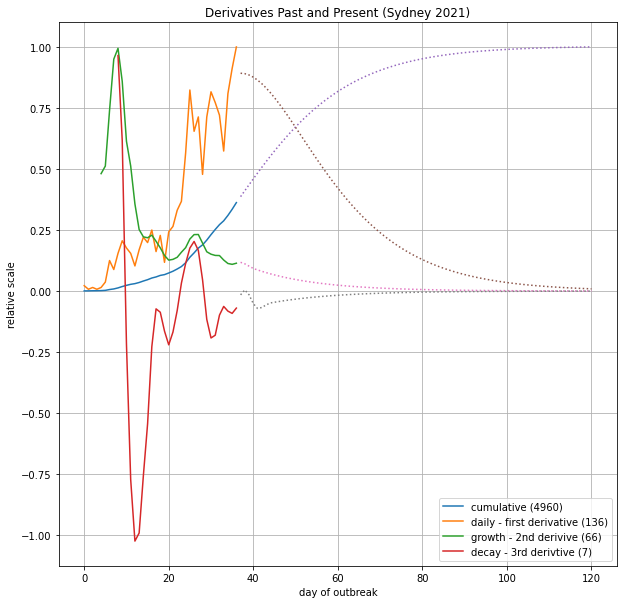

In [13]:
ax=plot_derivatives(bondi_projection_2, len(bondi), "Sydney 2021")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/derivatives-sydney-partial.png')

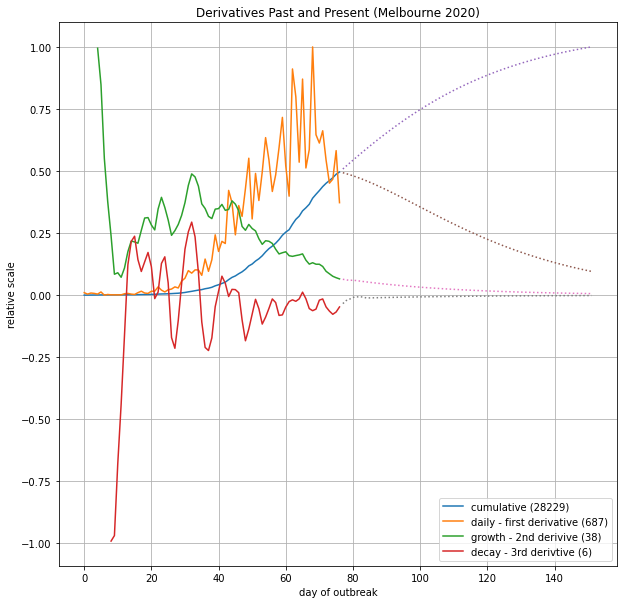

In [14]:
ax=plot_derivatives(vic_projection, len(vic_partial), dataset="Melbourne 2020")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/derivatives-melbourne-partial.png')

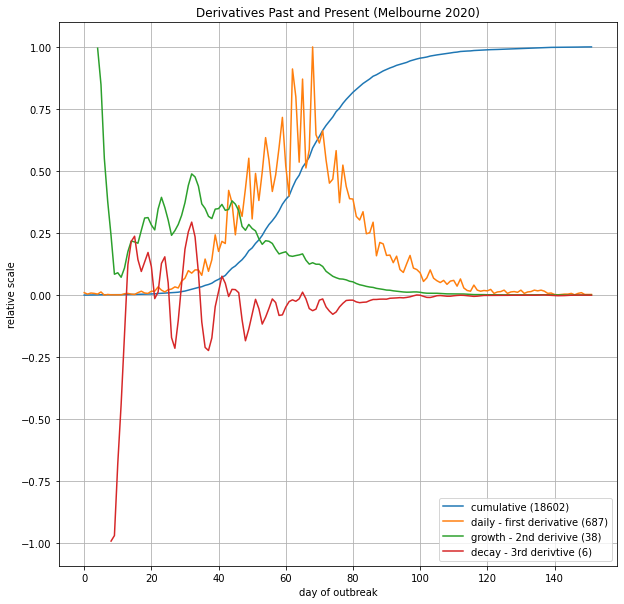

In [15]:
ax=plot_derivatives(vic_outbreak, None, dataset="Melbourne 2020")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/derivatives-melbourne-full.png')

In [16]:
bondi[["total", "cumulative", "one-day-projection-total", "one-day-projection-cumulative", "one-day-error", "ols-growth-rate", "ols-growth-rate-decay",  "doubling-period"]].tail(14)

,total,cumulative,one-day-projection-total,one-day-projection-cumulative,one-day-error,ols-growth-rate,ols-growth-rate-decay,doubling-period
23,50.0,498.0,52.0,550.0,9.0,10.498853,0.227778,6.942931
24,77.0,575.0,67.0,642.0,25.0,11.735914,0.792770,6.246371
25,112.0,687.0,97.0,784.0,45.0,14.069443,1.232237,5.265586
26,89.0,776.0,118.0,894.0,-8.0,15.262884,1.422391,4.879762
27,97.0,873.0,133.0,1006.0,-21.0,15.285946,1.165723,4.872899
28,65.0,938.0,122.0,1060.0,-68.0,12.956896,0.323967,5.689177
29,97.0,1035.0,110.0,1145.0,-25.0,10.619282,-0.813029,6.867996
30,111.0,1146.0,114.0,1260.0,1.0,9.965687,-1.345026,7.296425
31,105.0,1251.0,121.0,1372.0,-9.0,9.634387,-1.265592,7.535774
32,98.0,1349.0,129.0,1478.0,-23.0,9.595701,-0.691196,7.564800
